# Install and load the required packages

In [1]:
%%capture
# %%capture is to hide the installation details
!pip install pycox
# delete the pond sign to install the pycox package
# replace the pycox with the name of python package to be installed

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [2]:
import torch
import torchtuples as tt

from pycox.models import CoxPH # For continuous time SNN DeepSurv
from pycox.models import DeepHitSingle # For discrete time SNN DeepHit
from DeepSurv_DeepHit_func import EvalSurv # For evaluation metrics

In [3]:
# set the random seed for replication
np.random.seed(1234)
_ = torch.manual_seed(1234)

# Load and process PBC2 data

In [4]:
# Load Data
pbc2 = pd.read_pickle("pbc2long.pkl").groupby('id').first().reset_index()
# tstart, tstop, tstop_final: time in days
# xt: time-dependent variables
# x: baseline variables
print(pbc2)

        id  tstop_final  event_final  time   xt1    xt2   xt3     xt4    xt5  \
0      1.0         57.0          1.0   0.0  14.5  261.0  2.60  1718.0  138.0   
1      2.0        736.0          0.0   0.0   1.1  302.0  4.14  7395.0  113.5   
2      3.0        145.0          1.0   0.0   1.4  176.0  3.48   516.0   96.1   
3      4.0        275.0          1.0   0.0   1.8  244.0  2.54  6122.0   60.6   
4      5.0        215.0          0.0   0.0   3.4  279.0  3.53   671.0  113.2   
..     ...          ...          ...   ...   ...    ...   ...     ...    ...   
307  308.0        260.0          0.0   0.0   0.4  246.0  3.58   797.0   91.0   
308  309.0        237.0          0.0   0.0   0.4  260.0  2.75  1166.0   70.0   
309  310.0        229.0          0.0   0.0   1.7  434.0  3.35  1713.0  171.0   
310  311.0        215.0          0.0   0.0   2.0  247.0  3.16  1050.0  117.0   
311  312.0        208.0          0.0   0.0   6.4  576.0  3.79  2115.0  136.0   

       xt6  ...   x1   x2   x3   x4   x

In [5]:
df_train = pbc2.copy() # get the baseline observations
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Standardize continuous covariates (mean = 0, sd = 1)

In [6]:
feature = ['xt'+str(y+1) for y in range(20)]+['x'+str(y+1) for y in range(7)]
feature_tobe_scaled = ['xt'+str(y+1) for y in range(7)]+['x7']

standardize = [([col], StandardScaler()) for col in feature_tobe_scaled]
leave = [(col, None) for col in feature if col not in feature_tobe_scaled]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [8]:
get_target = lambda df: (df['tstop_final'].values.astype('float32'), df['event_final'].values.astype('float32'))
y_train = get_target(df_train)
y_val = get_target(df_val)
time_test, event_test = get_target(df_test)
val = x_val, y_val

# DeepSurv (Continuous Time Survival Neural Network)

In [9]:
# Setup the parameters for Neural Network
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False
batch_size = 128
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

net = tt.practical.MLPVanilla(in_features,
                              num_nodes,
                              out_features,
                              batch_norm,
                              dropout,
                              output_bias=output_bias)
DeepSurv = CoxPH(net, tt.optim.Adam)
DeepSurv.optimizer.set_lr(0.01)

In [10]:
DeepSurv_log = DeepSurv.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                            val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.0007,	val_loss: 2.8709
1:	[0s / 0s],		train_loss: 3.6999,	val_loss: 2.6303
2:	[0s / 0s],		train_loss: 3.6095,	val_loss: 2.5086
3:	[0s / 0s],		train_loss: 3.4345,	val_loss: 2.4509
4:	[0s / 0s],		train_loss: 3.3282,	val_loss: 2.4362
5:	[0s / 0s],		train_loss: 3.3380,	val_loss: 2.4250
6:	[0s / 0s],		train_loss: 3.4783,	val_loss: 2.4250
7:	[0s / 0s],		train_loss: 3.3079,	val_loss: 2.4310
8:	[0s / 0s],		train_loss: 3.3225,	val_loss: 2.4333
9:	[0s / 0s],		train_loss: 3.3053,	val_loss: 2.4437
10:	[0s / 0s],		train_loss: 3.2663,	val_loss: 2.4509
11:	[0s / 0s],		train_loss: 3.2284,	val_loss: 2.4649
12:	[0s / 0s],		train_loss: 3.2689,	val_loss: 2.4960
13:	[0s / 0s],		train_loss: 3.1908,	val_loss: 2.5370
14:	[0s / 0s],		train_loss: 3.1676,	val_loss: 2.5679
15:	[0s / 0s],		train_loss: 3.1109,	val_loss: 2.6290
16:	[0s / 0s],		train_loss: 2.9936,	val_loss: 2.6934


<Axes: >

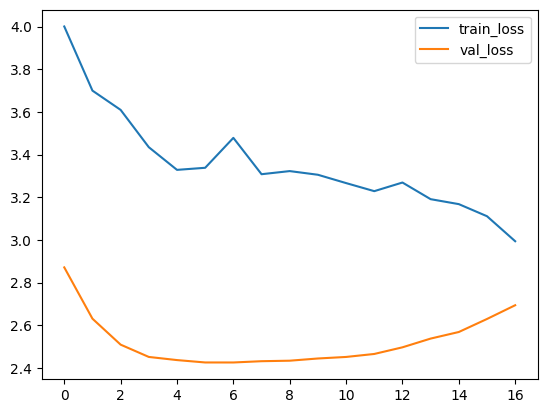

In [11]:
DeepSurv_log.plot()

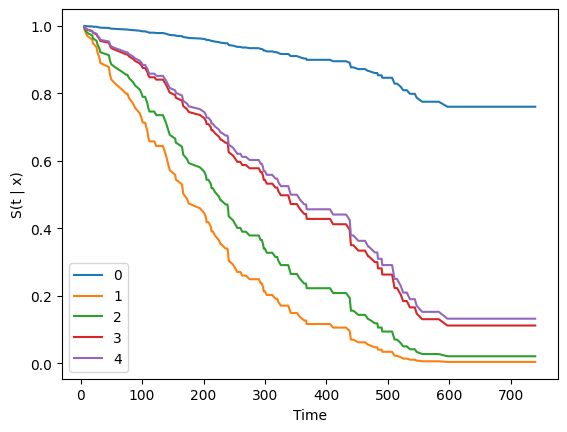

In [12]:
_ = DeepSurv.compute_baseline_hazards()
surv_DeepSurv = DeepSurv.predict_surv_df(x_test)
surv_DeepSurv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [13]:
%%capture
ev_DeepSurv = EvalSurv(surv_DeepSurv, time_test, event_test, censor_surv='km')

In [14]:
ev_DeepSurv.concordance_td()

0.8774774774774775

In [15]:
ev_DeepSurv.integrated_brier_score(np.linspace(time_test.min(), time_test.max(), 100)).item()

0.10293569474643101

# DeepHit (Discrete Time Survival Neural Network)

# Additional step for time-discretization is needed for discrete time SNN

In [16]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations) # label transformation: discretize the time
y_train_discrete = labtrans.fit_transform(*get_target(df_train))
y_val_discrete = labtrans.transform(*get_target(df_val))

train_discrete = (x_train, y_train_discrete)
val_discrete = (x_val, y_val_discrete)

# We don't need to discretize the test data for evaluation purpose

In [19]:
# Setup the parameters for Neural Network
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
batch_size = 128
epochs = 200
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

net = tt.practical.MLPVanilla(in_features,
                              num_nodes,
                              out_features,
                              batch_norm,
                              dropout)
DeepHit = DeepHitSingle(net,
                        tt.optim.Adam,
                        alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
DeepHit.optimizer.set_lr(0.01)

In [20]:
out_features

10

In [21]:
DeepHit_log = DeepHit.fit(x_train, y_train_discrete,
                          batch_size,
                          epochs,
                          callbacks,
                          verbose,
                          val_data=val_discrete)

0:	[0s / 0s],		train_loss: 0.6204,	val_loss: 0.4979
1:	[0s / 0s],		train_loss: 0.4621,	val_loss: 0.4722
2:	[0s / 0s],		train_loss: 0.4478,	val_loss: 0.4613
3:	[0s / 0s],		train_loss: 0.4087,	val_loss: 0.4578
4:	[0s / 0s],		train_loss: 0.3789,	val_loss: 0.4596
5:	[0s / 0s],		train_loss: 0.3528,	val_loss: 0.4616
6:	[0s / 0s],		train_loss: 0.3438,	val_loss: 0.4649
7:	[0s / 0s],		train_loss: 0.3502,	val_loss: 0.4655
8:	[0s / 0s],		train_loss: 0.3574,	val_loss: 0.4577
9:	[0s / 0s],		train_loss: 0.3266,	val_loss: 0.4404
10:	[0s / 0s],		train_loss: 0.3220,	val_loss: 0.4268
11:	[0s / 0s],		train_loss: 0.2996,	val_loss: 0.4187
12:	[0s / 0s],		train_loss: 0.2869,	val_loss: 0.4149
13:	[0s / 0s],		train_loss: 0.2933,	val_loss: 0.4136
14:	[0s / 0s],		train_loss: 0.2763,	val_loss: 0.4165
15:	[0s / 0s],		train_loss: 0.2623,	val_loss: 0.4267
16:	[0s / 0s],		train_loss: 0.2584,	val_loss: 0.4381
17:	[0s / 0s],		train_loss: 0.2437,	val_loss: 0.4509
18:	[0s / 0s],		train_loss: 0.2498,	val_loss: 0.4770
19:

<Axes: >

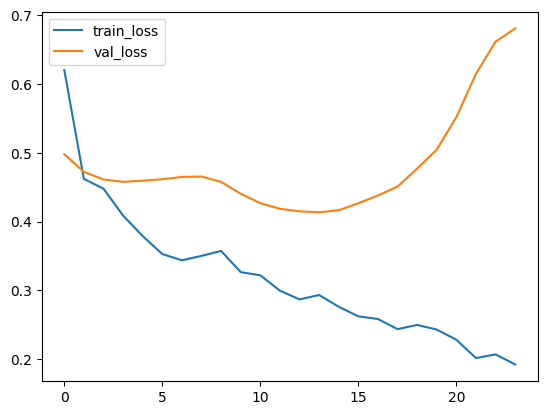

In [22]:
DeepHit_log.plot()

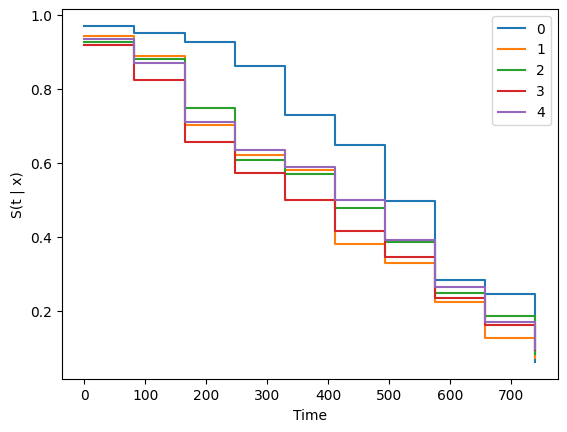

In [23]:
surv_DeepHit = DeepHit.predict_surv_df(x_test)
surv_DeepHit.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [24]:
%%capture
ev_DeepHit = EvalSurv(surv_DeepHit, time_test, event_test, censor_surv='km')

In [25]:
ev_DeepHit.concordance_td()

0.7828828828828829

In [26]:
ev_DeepHit.integrated_brier_score(np.linspace(time_test.min(), time_test.max(), 100)).item()

0.16867713332359363